In [1]:
#Package installs
!sudo apt install swig
!pip install gymnasium
!pip install gymnasium[box2d]

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 24 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 1s (1,618 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 2.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline


In [2]:
#imports
import gym
import gymnasium
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import base64, io
import numpy as np
from collections import deque, namedtuple
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob

In [3]:
#Lunar Lander environment on Un-trained Model
env = gym.make('LunarLander-v2')
env.reset()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


array([-2.5310516e-04,  1.4135162e+00, -2.5656849e-02,  1.1537305e-01,
        3.0012167e-04,  5.8116522e-03,  0.0000000e+00,  0.0000000e+00],
      dtype=float32)

In [4]:
#Video Output Settings
def show_video(env_name):
    vid_check = glob.glob('/content/sample_data/*.mp4')
#Uses glob.glob to list all *.mp4 files in the "/content/sample_data/" directory. The result is stored in the vid_check variable.
#Reading/Encoding Video
    if len(vid_check) > 0:
        mp4 = '/content/sample_data/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
#Displays an HTML5 video element using IPython's display module.
        display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))
        )
    else:
        print("No Video Found")


In [5]:
#Visualising interactions between a trained agent and the lunar lander environment
def show_model(agent, env_name):
    env = gym.make(env_name)
    vid_untrained = video_recorder.VideoRecorder(env, path="/content/sample_data/untrained_LunarLander-v2.mp4")
    state = env.reset()
    done = False
#Record Video Frames in a Loop
    while not done:
        frame = env.render(mode='rgb_array')
        vid_untrained.capture_frame()
        action = env.action_space.sample()
        state, reward, done, _ = env.step(action)
    vid_untrained.close()

env.close()


In [6]:
# Display the un-trained model
show_model(None, 'LunarLander-v2')
show_video('untrained_LunarLander-v2')

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead

In [ ]:
## We start by training the lunar lander to land in its environment using the DQN Model with Target

In [7]:
#This QNetwork class defines a simple feedforward neural network with three linear filly connected layers and ReLU activation functions.
#It takes a state as input and produces Q-values for each possible action as output, which serves as the approximation model for
#the Q-function in DQN

class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed):  #Initialize parameters and build model.

#Parameters:
#state_size: Dimensionality of the input state.
#action_size: Dimensionality of the output action.
#seed: Random seed for reproducibility.

#Defines three fully connected (linear) layers:
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, state):
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.fc3(x)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
#Parameters for training
BUFFER_SIZE = 10000  # replay buffer size
BATCH_SIZE = 64         # minibatch size 64
GAMMA = 0.99            # discount factor 0.99 0.9 0.95
TAU = 0.003              # for soft update of target parameters
LR = 0.001               # learning rate 2.5e-4  7e-4
UPDATE_EVERY = 4        # how often to update the network

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
#Agent learns and interacts with its given environment.
class Agent():
    def __init__(self, state_size, action_size, seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

#Q-Network_Local and Q-Network_Target are instances of the Q-Network class, representing the local and target Q-networks.
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

#Replay Memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        #Time step (for updating every 'UPDATE_EVERY' steps)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        #Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        self.criterion=nn.MSELoss()

        #Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
        #If there are a sufficient number of samples in memory, we obtain a random subset and proceed with the learning process.
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

#The state is converted to a PyTorch tensor and processed through the local Q-network and follows an epsilon-greedy strategy for action selection.
    def action(self, state, eps=0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

#Epsilon-greedy selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

#learn is called to update the Q-network value parameters using a batch of experiences.
    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences

#Computing and minimising the loss
        #Retrieve the next max estimated value from the target network
        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        #Q-targets are computed based on the Bellman equation.
        q_targets = rewards + gamma * q_targets_next * (1 - dones)
        #Expected values calculated from the local network
        q_expected = self.qnetwork_local(states).gather(1, actions)
        #The loss is calculated as the mean squared error between the expected and target Q-values.
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

#Update target network
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

#Performs a soft update of the target Q-network parameters using a weighted combination of the local and target parameters.
    def soft_update(self, local_model, target_model, tau):

#Parameters (PyTorch model):
#local_model: The origin/source of the weights for copying.
#target_model: The target model where the weights will be copied to.
#tau: Control/Adjust Interpolation parameter (float).

        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [11]:
#Experience Tuples are stored in the buffer
class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size, seed):

#Parameters:
    #action_size (int): Dimension of each action.
    #buffer_size (int): Maximum size of the buffer.
    #batch_size (int): Size of each training batch.
    #seed (int): Random seed.

        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
#Adding a new experience to replay buffer/memory by creating a namedtuple 'e' and appending it to the deque.
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

#Randomly sample a batch of experiences from the replay buffer.
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
#Creates tensors for states, actions, rewards, next_states, and dones from the sampled experiences to return tuples representing a batch of experiences.
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

#Displays the current size of the replay buffer or memory
    def __len__(self):
        return len(self.memory)

In [12]:
#This script employs a Deep Q-Network (DQN) agent with epsilon-greedy exploration to interact with an environment.
#It monitors and logs scores during training, saving the model if the average score exceeds 200.0 over the last 100 episodes.
#Key parameters, including maximum episodes, timesteps per episode, and epsilon decay, govern the training process.

def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):

#Parameters:
    #n_episodes (int): Max training episode count.
    #max_t (int): Max timesteps per episode.
    #eps_start (float): Initial epsilon value.
    #eps_end (float): Min epsilon value.
    #eps_decay (float): Multiplicative factor (per episode) for epsilon reduction.

    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.action(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score)
        scores.append(score)
        eps = max(eps_end, eps_decay*eps)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

agent = Agent(state_size=8, action_size=4, seed=0)
scores = dqn()

Episode 100	Average Score: -159.87
Episode 200	Average Score: -82.24
Episode 300	Average Score: 51.47
Episode 400	Average Score: 134.76
Episode 500	Average Score: 172.39
Episode 519	Average Score: 200.17
Environment solved in 419 episodes!	Average Score: 200.17


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


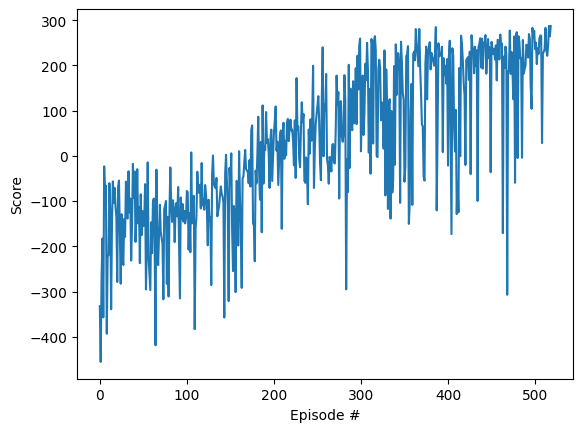

In [13]:
#Plot of the training scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [14]:
#Video Output Settings
def show_video(env_name):
    vid_check = glob.glob('/content/sample_data/*.mp4')
#Uses glob.glob to list all *.mp4 files in the "/content/sample_data/" directory. The result is stored in the vid_check variable.
#Reading/Encoding Video
    if len(vid_check) > 0:
        mp4 = '/content/sample_data/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
#Displays an HTML5 video element using IPython's display module.
        display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("No Video Found")

#Visualising interactions between a trained agent and the lunar lander environment
def show_model(agent, env_name, video_filename):
    env = gym.make(env_name)
    video_path = f"/content/sample_data/{video_filename}.mp4"
    vid = video_recorder.VideoRecorder(env, path=video_path)
    agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))
    state = env.reset()
    done = False
    #Record Video Frames in a Loop
    while not done:
        frame = env.render(mode='rgb_array')
        vid.capture_frame()
        action = agent.action(state)
        state, reward, done, _ = env.step(action)
    vid.close()
    env.close()


In [15]:
custom_video_filename = 'dqn_Lunar_Lander_V2'
agent = Agent(state_size=8, action_size=4, seed=0)
show_model(agent, 'LunarLander-v2', custom_video_filename)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 

In [16]:
#Display DQN trained model
show_video('dqn_Lunar_Lander_V2')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#Double DQN

In [17]:
#This QNetwork class defines a simple feedforward neural network with three linear filly connected layers and ReLU activation functions.
#It takes a state as input and produces Q-values for each possible action as output, which serves as the approximation model for
#the Q-function in DQN

class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed):  #Initialize parameters and build model.

#Parameters:
#state_size: Dimensionality of the input state.
#action_size: Dimensionality of the output action.
#seed: Random seed for reproducibility.

#Defines three fully connected (linear) layers:
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, state):
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.fc3(x)

In [18]:
#Parameters for training
BUFFER_SIZE = 10000  # replay buffer size
BATCH_SIZE = 64         # minibatch size 64 32
GAMMA = 0.99            # discount factor 0.99 0.9 0.95
TAU = 0.003              # for soft update of target parameters
LR = 0.001               # learning rate 2.5e-4  7e-4
UPDATE_EVERY = 4        # how often to update the network

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [20]:
#Agent learns and interacts with its given environment.
class Agent():
    def __init__(self, state_size, action_size, seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

#Q-Network_Local and Q-Network_Target are instances of the Q-Network class, representing the local and target Q-networks.
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

#Replay Memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        #Time step (for updating every 'UPDATE_EVERY' steps)
        self.t_step = 0
        self.criterion=nn.MSELoss()

    def step(self, state, action, reward, next_state, done):
        #Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

        #Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
        #If there are a sufficient number of samples in memory, we obtain a random subset and proceed with the learning process.
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

#The state is converted to a PyTorch tensor and processed through the local Q-network and follows an epsilon-greedy strategy for action selection.
    def action(self, state, eps=0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

#Epsilon-greedy selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

#learn is called to update the Q-network value parameters using a batch of experiences.
    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences

        #Computing and minimising the loss
        #Expected values calculated from the local network
        q_expected = self.qnetwork_local(states).gather(1, actions)
        #Get the action values from the online network
        next_action_values = self.qnetwork_local(next_states).max(1)[1].unsqueeze(-1)
        #Retrieve the next max estimated value from the target network
        q_targets_next = self.qnetwork_target(next_states).gather(1, next_action_values).detach().max(1)[0].unsqueeze(1)
        #Q-targets are computed based on the Bellman equation.
        q_targets = rewards + gamma * q_targets_next * (1 - dones)

        #The loss is calculated as the mean squared error between the expected and target Q-values.
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

#Update target network
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

#Performs a soft update of the target Q-network parameters using a weighted combination of the local and target parameters.
    def soft_update(self, local_model, target_model, tau):

#Parameters (PyTorch model):
#local_model: The origin/source of the weights for copying.
#target_model: The target model where the weights will be copied to.
#tau: Control/Adjust Interpolation parameter (float).

        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [21]:
#Experience Tuples are stored in the buffer
class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size, seed):

#Parameters:
    #action_size (int): Dimension of each action.
    #buffer_size (int): Maximum size of the buffer.
    #batch_size (int): Size of each training batch.
    #seed (int): Random seed.

        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
#Adding a new experience to replay buffer/memory by creating a namedtuple 'e' and appending it to the deque.
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

#Randomly sample a batch of experiences from the replay buffer.
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
#Creates tensors for states, actions, rewards, next_states, and dones from the sampled experiences to return tuples representing a batch of experiences.
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

#Displays the current size of the replay buffer or memory
    def __len__(self):
        return len(self.memory)

In [22]:
#This script employs a Double Deep Q-Network (DQN) agent with epsilon-greedy exploration to interact with an environment.
#It monitors and logs scores during training, saving the model if the average score exceeds 200.0 over the last 100 episodes.
#Key parameters, including maximum episodes, timesteps per episode, and epsilon decay, govern the training process.

def ddqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):

#Parameters:
    #n_episodes (int): Max training episode count.
    #max_t (int): Max timesteps per episode.
    #eps_start (float): Initial epsilon value.
    #eps_end (float): Min epsilon value.
    #eps_decay (float): Multiplicative factor (per episode) for epsilon reduction.

    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.action(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score)
        scores.append(score)
        eps = max(eps_end, eps_decay*eps)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

agent = Agent(state_size=8, action_size=4, seed=0)
scores = ddqn()

Episode 100	Average Score: -148.84
Episode 200	Average Score: -80.85
Episode 300	Average Score: -27.81
Episode 400	Average Score: 8.44
Episode 500	Average Score: 124.57
Episode 598	Average Score: 200.37
Environment solved in 498 episodes!	Average Score: 200.37


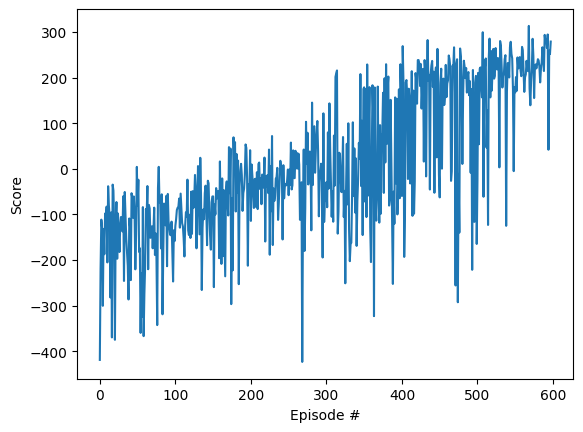

In [23]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [24]:
#Video Output Settings
def show_video(env_name):
    vid_check = glob.glob('/content/sample_data/*.mp4')
#Uses glob.glob to list all *.mp4 files in the "/content/sample_data/" directory. The result is stored in the vid_check variable.
#Reading/Encoding Video
    if len(vid_check) > 0:
        mp4 = '/content/sample_data/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
#Displays an HTML5 video element using IPython's display module.
        display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("No Video Found")

#Visualising interactions between a trained agent and the lunar lander environment
def show_model(agent, env_name, video_filename):
    env = gym.make(env_name)
    video_path = f"/content/sample_data/{video_filename}.mp4"
    vid = video_recorder.VideoRecorder(env, path=video_path)
    agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))
    state = env.reset()
    done = False
    #Record Video Frames in a Loop
    while not done:
        frame = env.render(mode='rgb_array')
        vid.capture_frame()
        action = agent.action(state)
        state, reward, done, _ = env.step(action)
    vid.close()
    env.close()


In [25]:
custom_video_filename = 'ddqn_Lunar_Lander_V2'
agent = Agent(state_size=8, action_size=4, seed=0)
show_model(agent, 'LunarLander-v2', custom_video_filename)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 

In [27]:
#Display DDQN trained model
show_video('ddqn_Lunar_Lander_V2')

In [ ]:
#Deulling DQN

In [ ]:
class DuelingQNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed):
        super(DuelingQNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)

        # Shared feature layer
        self.feature_layer = nn.Sequential(
            nn.Linear(state_size, 64),
            nn.ReLU()
        )

        # Value layer
        self.value_stream = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

        # Advantage layer
        self.advantage_stream = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, action_size)
        )

    def forward(self, state):
        x = self.feature_layer(state)
        value = self.value_stream(x)
        advantage = self.advantage_stream(x)
        q_values = value + (advantage - advantage.mean(dim=1, keepdim=True))
        return q_values

In [ ]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate
UPDATE_EVERY = 4        # how often to update the network

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.

        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def action(self, state, eps=0.):
        """Returns actions for given state as per current policy.

        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values_local = self.qnetwork_local(state)
            best_action_local = action_values_local.argmax(1).unsqueeze(1)
            action_values_target = self.qnetwork_target(state).detach()
            action_values = action_values_target.gather(1, best_action_local)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
#       Obtain random minibatch of tuples from D
        states, actions, rewards, next_states, dones = experiences

        ## Compute and minimize the loss
        ### Use online network to select actions for next states
        next_actions = self.qnetwork_local(next_states).detach().max(1)[1].unsqueeze(1)
        ### Use target network to evaluate Q-values for next states and selected actions
        q_targets_next = self.qnetwork_target(next_states).gather(1, next_actions)
        ### Calculate target value from Bellman equation
        q_targets = rewards + gamma * q_targets_next * (1 - dones)
        ### Calculate expected value from local network
        q_expected = self.qnetwork_local(states).gather(1, actions)

        ### Loss calculation (Mean squared error)
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [ ]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [ ]:
def duel_dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Double Q-Learning.

    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.action(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window) >= 200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

agent = Agent(state_size=8, action_size=4, seed=0)
scores = duel_dqn()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Episode 100	Average Score: -183.40
Episode 200	Average Score: -141.65
Episode 300	Average Score: -59.42
Episode 400	Average Score: -28.52
Episode 474	Average Score: -0.41

KeyboardInterrupt: ignored

In [ ]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
def show_video(env_name):
    vid_check = glob.glob('/content/sample_data/*.mp4')
    if len(vid_check) > 0:
        mp4 = '/content/sample_data/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def show_model(agent, env_name, video_filename):
    env = gym.make(env_name)
    video_path = f"/content/sample_data/{video_filename}.mp4"
    vid = video_recorder.VideoRecorder(env, path=video_path)
    agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))
    state = env.reset()
    done = False
    while not done:
        frame = env.render(mode='rgb_array')
        vid.capture_frame()

        action = agent.action(state)

        state, reward, done, _ = env.step(action)
    vid.close()
    env.close()


In [ ]:
custom_video_filename = 'DDQN_Lunar_Lander_V2'
agent = Agent(state_size=8, action_size=4, seed=0)
show_model(agent, 'LunarLander-v2', custom_video_filename)

In [ ]:
show_video('DDQN_Lunar_Lander_V2')